<a href="https://colab.research.google.com/github/tsiligardi/PRA3024-Analysis-of-big-data-in-physics/blob/main/GWDA_Ex_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
!{sys.executable} -m pip install lalsuite pycbc


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive') #Mounting google drive on colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**PROBLEM 1**

In [3]:
#!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
#!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

In [4]:
#Import the usefull libraries
%matplotlib inline
import pylab
import lal
from pycbc.filter import highpass,matched_filter
from pycbc.conversions import mass1_from_mchirp_q
from pycbc.catalog import Merger
from pycbc.frame import read_frame
from pycbc.filter import resample_to_delta_t, highpass
import numpy as np
from pycbc import types
from pycbc.waveform import get_td_waveform,get_fd_waveform
from pycbc.waveform import td_approximants, fd_approximants
import pycbc.psd
from pycbc.psd import interpolate


Part 1: Download the data set from [1]. This data set contains a noise time series and an addi-
tional gravitational wave signal, where the sampling rate of the time series is 16384Hz.
The first column of the data set refers to the time. The second and third columns
are the data recorded by LIGO Hanford and Livingston, respectively. For the sake of
convenience in data analysis, we downsample the data at a sampling rate of 2048Hz

In [5]:
#Importing the data, assuming they are stored on drive and we are working on colab.
#I had to adopted this solutions, since the fram package suddenly stopped work for everyone
d = np.load('/content/drive/MyDrive/GW_noisedata-2.npy')

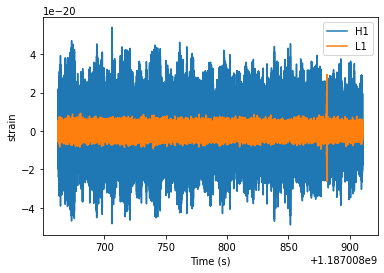

In [6]:
dt = d[:, 0]
i=1
strain, stilde = {}, {}
for ifo in ['H1', 'L1']:
  ts = types.TimeSeries(d[:, i], delta_t = dt[1]- dt[0],epoch=dt[0])#eopch: set start time of the time series
   # Read the detector data and remove low frequency content
  strain[ifo] = resample_to_delta_t(highpass(ts, 15.0), 1.0/2048)
 
   # Remove time corrupted by the high pass filter
  strain[ifo] = strain[ifo].crop(4, 4)
  
   # Also create a frequency domain version of the data
  stilde[ifo] = strain[ifo].to_frequencyseries()
  i+=1
#print (strain.delta_t)
pylab.plot(strain['H1'].sample_times, strain['H1'], label= 'H1')
pylab.plot(strain['L1'].sample_times, strain['L1'], label= 'L1')
pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('strain')
pylab.show()


Part 2- Write down the code to calculate the matched filter between the given data and a
template waveform. After that, find out the template waveform for which the signal
to noise ratio is maximum. For simplicity, you can assume the template waveform is
produced from an equal mass binary system. Produce a plot which shows the SNR
versus total mass of the system, where masses of the systems are uniformly distributed
in a range 1M ≤ m1,2 ≤ 3M (use m1 = m2). Represent the result by fitting the
best match template waveform against the data. Also, show the chirp structure of the
signal over the time-frequency domain using Q-transformation().

In [7]:
#To determine the signal to noise ration, we first need to determine the power spectral density

psds = {}
for ifo in ['L1', 'H1']:

    delta_t = strain[ifo].delta_t
    seg_len = int(2 / delta_t)
    seg_stride = int(seg_len / 2) #how much overlapping of the segments
    psds[ifo]  = pycbc.psd.welch(strain[ifo],#power spectral density
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)

In [8]:
# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = []
masses=np.arange(1,3,0.01)
for m in masses:
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
    hp, hc = get_fd_waveform(approximant="TaylorF2", 
                             mass1=m, mass2=m, 
                             f_lower=20, delta_f=stilde[ifo].delta_f)
    hp.resize(len(stilde[ifo]))
    
    # Matched filter the data and find the peak  
    max_snr, max_time = {}, {}
    for ifo in ['L1', 'H1']:
        snr = matched_filter(hp, stilde[ifo], psd=psds[ifo], low_frequency_cutoff=20.0)
        snr_H1=snr.crop(4+4,4)

        # # The complex SNR at the peak
       
        _, idx = snr_H1.abs_max_loc()
        max_snr[ifo] = snr_H1[idx]
        
    
    #network_snr = (abs(np.array(list(max_snr.values()))) ** 2.0).sum() ** 0.5
    snrs.append(max_snr)


the best mass1=mass2 is 1.3800000000000003 solar masses


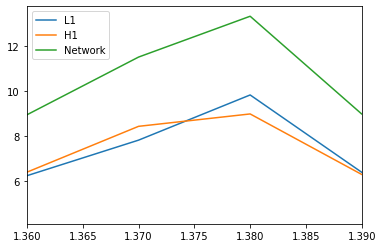

In [9]:
snrs_L1=[abs(snr['L1']) for snr in snrs]
snrs_H1=[abs(snr['H1']) for snr in snrs]
nsnr=(np.array(snrs_L1)**2+np.array(snrs_H1)**2)**0.5
pylab.plot(masses,snrs_L1,label='L1')
pylab.plot(masses,snrs_H1,label='H1')
pylab.plot(masses,nsnr,label='Network')
pylab.xlim(1.360,1.390)
pylab.legend()

ii=np.where(nsnr==max(nsnr))
print('the best mass1=mass2 is {} solar masses'.format(masses[ii][0]))

The L1 detector shows an SNR>8, indicating that an event has been detected there

In [10]:
#Now I need to recreate my template using the mass that gives the minimum signal-to-noise ratio
# which I found in the previous part
#Try to look at this tutorial: https://github.com/gwastro/PyCBC-Tutorials/blob/master/tutorial/3_WaveformMatchedFilter.ipynb. 
conditioned = stilde['H1']
hp, hc = get_fd_waveform(approximant="TaylorF2",
                     mass1=1.38,
                     mass2=1.38,
                     delta_f=conditioned.delta_f,
                     f_lower=15)

hp.resize(len(conditioned))
template = hp .cyclic_time_shift(hp.start_time)

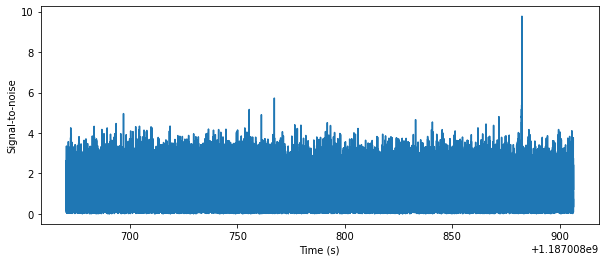

We found a signal at 1187008882.425879s with SNR 9.773094315428095


In [11]:
#Now I can fit the new template to the data, to see when the SNR peak happens
ifo = 'L1'                            
                  
conditioned = stilde[ifo]
snr = matched_filter(template, conditioned,
                     psd=psds[ifo] , low_frequency_cutoff=15)
snr = snr.crop(4 + 4, 4)
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

In [12]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=15.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

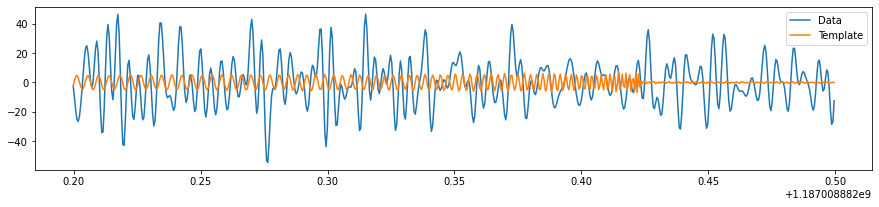

In [13]:
# We do it this way so that we can whiten both the template and the data
merger = Merger("GW170817")#getting the time of the event
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
#white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

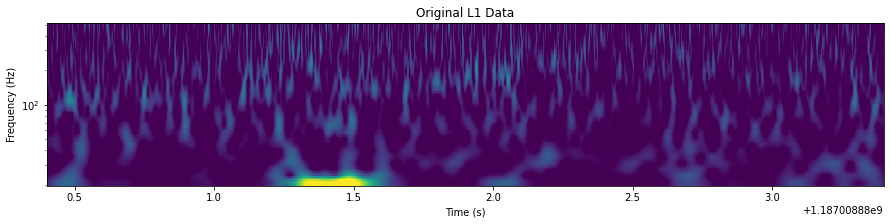

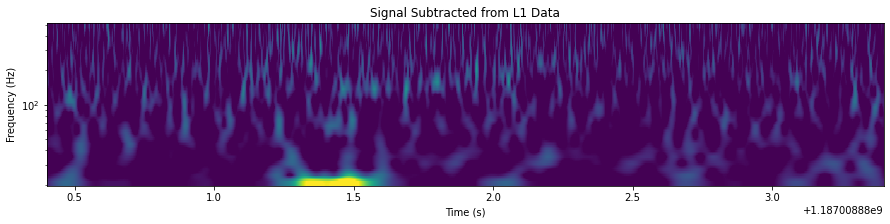

In [14]:
conditioned=conditioned.to_timeseries()
subtracted= conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original L1 Data'),
                    (subtracted, 'Signal Subtracted from L1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(merger.time - 2, merger.time + 1)
    pylab.show()


Part 3: Here, we would like to investigate the correlation in the parameter space of gravita-
tional waves from compact binary coalescences. Let us consider a gravitational wave
h∗(t; m1,m2) generated from a binary with masses m1 = m2 = 10M . Now, we want
to understand how the nearby templates are correlated with that waveform. Calculate
the match between h∗(t; m1,m2) and the nearby templates that are generated assuming 5M ≤ m1,m2 ≤ 15M . Of course, one should have the maximum match (= 1)
when hi = h∗. You will see that the match between two nearby waveforms is not zero.
So, one can realize the gravitational waveforms are correlated for two nearby points
in the parameter space. This fact is used to produce a template bank for detecting
gravitational waves.

In [17]:
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter import match
mass=10
f_low=30
sample_rate=4096
hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=10,
                     mass2=10,
                     delta_t=1/sample_rate,
                     f_lower=30) #creating the first wave form
mass_range = np.arange(5, 15,0.5 )#They are not many, but in this way I can speed up a bit the process
h_to_compare=[]#array to store the wave form that I have to compare with the other
for m in mass_range:
  sp,sc=get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=1/sample_rate,
                     f_lower=30)
  h_to_compare.append(sp)

#Resizing all the waveforms so that they all have te same size
tlen=max(len(hp),len(h_to_compare[0]))
hp.resize(tlen)
for i in h_to_compare:
  i.resize(tlen)
#Now I can compare them
m_values=[]
for h in h_to_compare:
  delta_f=1.0/h.duration
  flen=tlen//2 +1
  psd=aLIGOZeroDetHighPower(flen, delta_f,f_low)
  m,i=match(hp,h,psd=psd,low_frequency_cutoff=f_low)
  m_values.append(m)

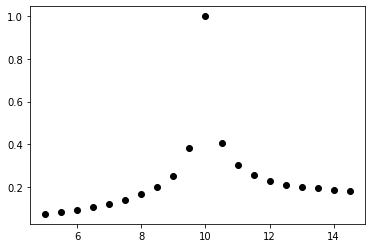

In [18]:
#Now I can plot the graph

pylab.plot(mass_range, m_values, 'o', color='black');


The plot shows what expected: the closer the waveform get, the more correlated they are. The maximum is for m=10 (the two waveforms are the same).